# Images with Minimal Background

**Scott Prahl**

**March 2020, Version 2**

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

import laserbeamsize as lbs

pixel_size_mm = 3.75/1000           # pixel size in mm for the camera

## Closely centered beam

Bright center, low background.  Beam is roughly 1/10 of the entire image.  Could not be easier.  

This is a Helium-Neon laser beam that is operating close to the TEM$_{00}$ mode.

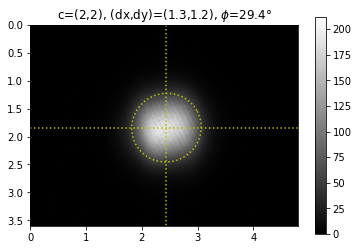

In [2]:
beam = imageio.imread("t-hene.pgm")

xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(beam)
lbs.plot_image_and_ellipse(beam,xc_found, yc_found, dx_found, dy_found, phi_found, scale=pixel_size_mm)

### Show cross sections

The circle drawn above certainly looks plausible, but what do cross sections (horizontal and vertical) look like?

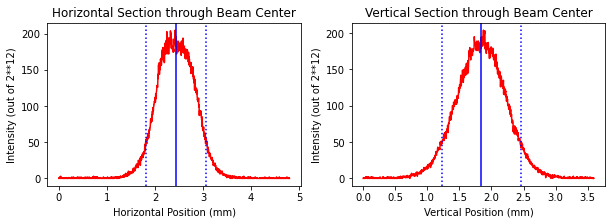

In [3]:
f, ax = plt.subplots(1,2,figsize=(10,3))

v,h = beam.shape
xcc = xc_found * pixel_size_mm
ycc = yc_found * pixel_size_mm
dxx = dx_found * pixel_size_mm
dyy = dy_found * pixel_size_mm

# plot a horizontal cross section 
xpos = np.arange(h)*pixel_size_mm
ypos = np.arange(v)*pixel_size_mm
hcenter=int(xc_found)
vcenter=int(yc_found)
plt.subplot(1,2,1)
plt.plot(xpos,beam[vcenter,:],color='red')
plt.axvline(xcc, color='blue')
plt.axvline(xcc+dxx/2,linestyle=":",color='blue')
plt.axvline(xcc-dxx/2,linestyle=":",color='blue')

plt.xlabel('Horizontal Position (mm)')
plt.ylabel('Intensity (out of 2**12)')
plt.title("Horizontal Section through Beam Center")

plt.subplot(1,2,2)
plt.plot(ypos,beam[:,hcenter],color='red')
plt.axvline(ycc, color='blue')
plt.axvline(ycc+dyy/2,linestyle=":",color='blue')
plt.axvline(ycc-dyy/2,linestyle=":",color='blue')

plt.xlabel('Vertical Position (mm)')
plt.ylabel('Intensity (out of 2**12)')
plt.title("Vertical Section through Beam Center")
plt.show()

Further analysis of this beam image can be found in the Jupyter notebook on the [razor blade technique](05-Razor-Blade.html)

## Twelve different images near focus

This shows how the default threshold of 0.1 (ten percent of the maximum value in the image) works with a good set of images.  

These are reasonable noise-free images measured near the focus of a beam.  

In [4]:
# array of distances at which images were collected
z1 = [168,210,280,348,414,480,495,510,520,580,666,770] #mm

# array of filenames associated with each image
fn1 = ["t-%dmm.pgm" % number for number in z1]

# read them all into memory 
test_img = [imageio.imread(fn) for fn in fn1]

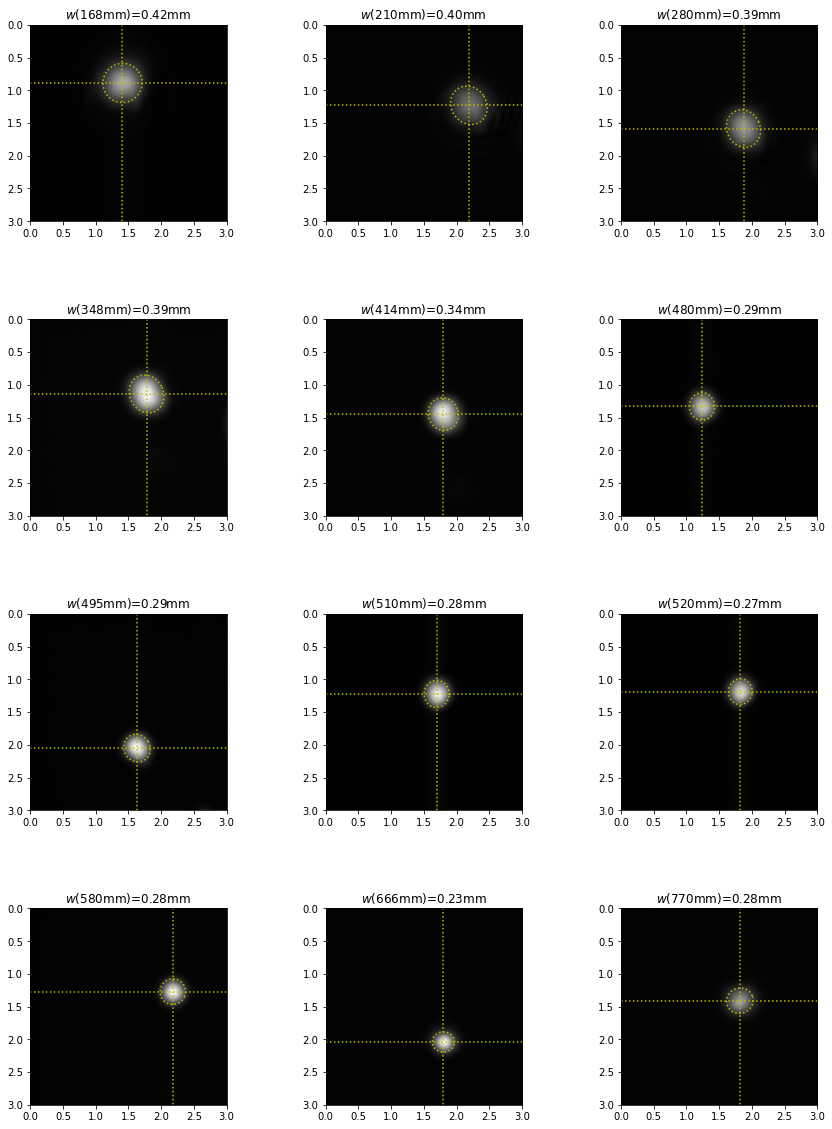

In [39]:
f, axs = plt.subplots(4,3,figsize=(15,15))

radii = np.empty(len(test_img))

for i, test in enumerate(test_img):
    plt.subplot(4,3,i+1)

    # show the beam image with actual dimensions on the axes
    v,h=test.shape
    plt.imshow(test, extent=[0,h* pixel_size_mm,v* pixel_size_mm,0], cmap='gray')

    # find the beam center and show it
    xc, yc, dx, dy, phi = lbs.beam_size(test)
    plt.plot([xc* pixel_size_mm,xc* pixel_size_mm],[0,v* pixel_size_mm],':y')
    plt.plot([0,h* pixel_size_mm],[yc* pixel_size_mm,yc* pixel_size_mm],':y')

    # show ellipse around beam
    xp,yp = lbs.ellipse_arrays(xc,yc,dx,dy,phi)
    plt.plot(xp* pixel_size_mm,yp* pixel_size_mm,':y')

    plt.xlim(0,h* pixel_size_mm)
    plt.ylim(v* pixel_size_mm,0)

    # calculate 1/e^2 radius for symmetric beam to label image
    r=np.sqrt(dx**2+dy**2)/2*pixel_size_mm
    radii[i] = r
    plt.title('$w$(%dmm)=%.2fmm'%(z1[i],r))

plt.subplots_adjust(bottom=0.0, top=1.0, hspace=0.5)
plt.show()


The algorithm finds each beam and produces reasonable beam diameters.

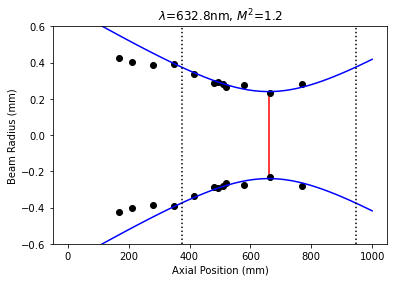

In [61]:
def z_rayleigh(w0,lambda0):
    """
    Return the Rayleigh distance.
    Args:
        w0 : minimum beam radius [m]
        lambda0: wavelength of light [m]
    Returns:
        distance where irradiance drops by 1/2 [m]
    """
    return np.pi * w0**2/lambda0



def beam_radius(w0,z0,M2,lambda0,z):
    """
    Return the beam radius at an axial location.
    Args:
        w0 : minimum beam radius [m]
        z0 : axial location of beam waist [m]
        M2 : beam propagation factor [-]
        lambda0: wavelength of light [m]
        z : axial location of desired beam radius [m]
    Returns:
        Beam radius [m]
    """
    return w0*np.sqrt(1+(M2*(z-z0)/z_rayleigh(w0,lambda0))**2)

M2 = 1.2
w0 = 0.24e-3                          # m
z0 = 660e-3                           # m
lambda0 = 632.8e-9                    # m

zR = z_rayleigh(w0,lambda0)           # m
zz = np.linspace(0,1000,50)*1e-3      # m
rr = beam_radius(w0,z0,M2,lambda0,zz) # m

plt.plot(z1,radii,'ok')
plt.plot(z1,-radii,'ok')
plt.plot(zz*1000,rr*1000,'b')
plt.plot(zz*1000,-rr*1000,'b')
plt.xlabel('Axial Position (mm)')
plt.ylabel('Beam Radius (mm)')
plt.title('$\lambda$=632.8nm, $M^2$=%.1f' % M2)
plt.axvline((z0-zR)*1000, color='black', linestyle=':')
plt.axvline((z0+zR)*1000, color='black', linestyle=':')
plt.vlines(z0*1000, ymin=-w0*1000, ymax=w0*1000, color='red')
plt.ylim(-0.6,0.6)
plt.show()

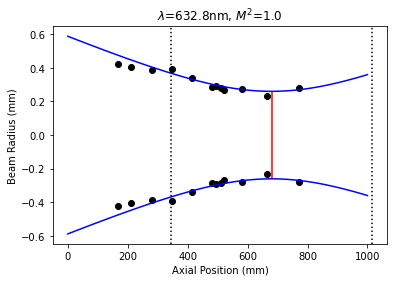

In [60]:
M2 = 1.0
w0 = 0.26e-3                          # m
z0 = 680e-3                           # m
lambda0 = 632.8e-9                    # m

zR = z_rayleigh(w0,lambda0)           # m
zz = np.linspace(0,1000,50)*1e-3      # m
rr = beam_radius(w0,z0,M2,lambda0,zz) # m

plt.plot(z1,radii,'ok')
plt.plot(z1,-radii,'ok')
plt.plot(zz*1000,rr*1000,'b')
plt.plot(zz*1000,-rr*1000,'b')
plt.xlabel('Axial Position (mm)')
plt.ylabel('Beam Radius (mm)')
plt.title('$\lambda$=632.8nm, $M^2$=%.1f' % M2)
plt.axvline((z0-zR)*1000, color='black', linestyle=':')
plt.axvline((z0+zR)*1000, color='black', linestyle=':')
plt.vlines(z0*1000, ymin=-w0*1000, ymax=w0*1000, color='red')


plt.show()